In [1]:
import os
import json
import gc
#base import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# about sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.ensemble import RandomForestClassifier
#about time
import time
import datetime 
from datetime import datetime, timedelta

from collections import Counter 
from statistics import mode 
    #warning
import warnings
warnings.filterwarnings("ignore")
import math
from itertools import product
import re

In [2]:
#把现有的csv也读进来
mortgage=pd.read_csv('./mortgage/mortgage_00_12.csv')
hpi_msa=pd.read_csv('./macro/hpi_msa.csv')
hpi_state=pd.read_csv('./macro/hpi_state.csv')
income_msa=pd.read_csv('./macro/income_msa.csv')
income_state=pd.read_csv('./macro/income_state.csv')
rate=pd.read_csv('./macro/rate.csv')
unemployment_msa=pd.read_csv('./macro/unemployment_msa.csv')
unemployment_state=pd.read_csv('./macro/unemployment_state.csv')

In [3]:
#看看最主要的csv里都有什么
pd.set_option('display.max_columns', None)
mortgage

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,orig_trm,oltv,ocltv,dti,cscore_b,mi_pct,fthb_flg,num_bo,purpose,prop_typ,num_unit,occ_stat,state,zip_3,cd_msa,delinquent60,delinquent90,foreclosure,prepaid_cnt,orig_chn,seller,f30_dte,f60_dte,f90_dte,fce_dte
0,FD,F100Q1023070,2000,1,0,04/01/00,8.500,204000,360,79,79,37,643,0,N,2,P,SF,1,P,AK,995,11260.0,0,0,0,1,NaN,COUNTRYWIDE,NaN,NaN,NaN,NaN
1,FD,F100Q1039162,2000,1,0,05/01/00,8.375,100000,360,34,34,19,796,0,N,2,P,SF,1,P,AK,998,NaN,0,0,0,1,NaN,"NORWESTMORTGAGE,INC",NaN,NaN,NaN,NaN
2,FD,F100Q1050054,2000,1,0,03/01/00,8.500,173000,360,95,95,43,698,25,N,2,P,SF,1,P,AK,995,11260.0,0,0,0,1,NaN,"NORWESTMORTGAGE,INC",NaN,NaN,NaN,NaN
3,FD,F100Q1002153,2000,1,0,03/01/00,8.125,137000,360,80,80,28,716,0,N,2,P,SF,1,P,AL,365,NaN,0,0,0,1,R,"NORWESTMORTGAGE,INC",NaN,NaN,NaN,NaN
4,FD,F100Q1005553,2000,1,0,03/01/00,8.250,92000,360,95,95,42,680,30,N,2,P,SF,1,P,AL,350,13820.0,0,0,0,1,R,Other sellers,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434589,FN,759306063952,2012,4,0,12/01/12,3.000,171000,360,95,95,29,786,30,Y,1,P,SF,1,P,WY,820,NaN,0,0,0,0,B,OTHER,NaN,NaN,NaN,NaN
434590,FN,793355164169,2012,4,0,02/01/13,3.375,191000,360,95,95,27,798,30,N,1,P,SF,1,P,WY,827,NaN,0,0,0,0,R,OTHER,NaN,NaN,NaN,NaN
434591,FN,801994828971,2012,4,0,01/01/13,3.250,171000,360,90,90,33,768,25,N,2,P,SF,1,P,WY,828,NaN,0,0,0,0,C,U.S. BANK N.A.,NaN,NaN,NaN,NaN
434592,FN,806029356254,2012,4,0,12/01/12,3.500,198000,360,80,80,41,772,0,N,2,P,SF,1,P,WY,820,NaN,0,0,0,0,B,OTHER,NaN,NaN,NaN,NaN


In [4]:
#把需要的特征做出表并命名为poly_features
poly_features =mortgage[['orig_rt','orig_amt','oltv','dti','cscore_b','mi_pct','fthb_flg','num_bo','num_unit','cd_msa','prepaid_cnt']]

In [5]:
#把宏观的表按周和季度匹配到总表里（合并之前先改名）
hpi_state=hpi_state.rename(columns={'year':'Year_orig','quarter':'Quarter_orig'})
income_state=income_state.rename(columns={'year':'Year_orig','quarter':'Quarter_orig'})
unemployment_state=unemployment_state.rename(columns={'year':'Year_orig','quarter':'Quarter_orig'})
rate=rate.rename(columns={'year':'Year_orig'})
clo3=[]
for i in range(rate.shape[0]):
    clo3.append(int(rate['month'][i]/4)+1)
rate['Quarter_orig']=clo3

In [6]:
#房价指数
loan_left=pd.merge(mortgage,hpi_state,how='left')
poly_features['HPI_state']=loan_left['HPI_state']

In [7]:
#s收入
loan_left=pd.merge(mortgage,income_state,how='left')
poly_features['weekly_income']=loan_left['weekly_income']

In [8]:
#失业率
loan_left=pd.merge(mortgage,unemployment_state,how='left')
poly_features['unemployment_rate']=loan_left['unemployment_rate']

In [9]:
#利率
loan_left=pd.merge(mortgage,rate,how='left')
poly_features['FRM30_rate']=loan_left['FRM30_rate']
poly_features['treasury_3mon_rate']=loan_left['treasury_3mon_rate']

In [10]:
poly_features

,orig_rt,orig_amt,oltv,dti,cscore_b,mi_pct,fthb_flg,num_bo,num_unit,cd_msa,prepaid_cnt,HPI_state,weekly_income,unemployment_rate,FRM30_rate,treasury_3mon_rate
0,8.500,204000,79,37,643,0,N,2,1,11260.0,1,169.95000,674.0,7.4,8.2100,5.32
1,8.375,100000,34,19,796,0,N,2,1,NaN,1,169.95000,674.0,7.5,8.3250,5.55
2,8.500,173000,95,43,698,25,N,2,1,11260.0,1,169.95000,674.0,7.2,8.2400,5.69
3,8.125,137000,80,28,716,0,N,2,1,NaN,1,209.11000,555.0,6.7,8.2100,5.32
4,8.250,92000,95,42,680,30,N,2,1,13820.0,1,209.11000,555.0,6.4,8.3250,5.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434589,3.000,171000,95,29,786,30,Y,1,1,NaN,0,270.35999,908.0,4.5,6.2175,4.98
434590,3.375,191000,95,27,798,30,N,1,1,NaN,0,270.35999,908.0,4.7,6.2850,5.03
434591,3.250,171000,90,33,768,25,N,2,1,NaN,0,270.35999,908.0,4.3,6.1560,4.94
434592,3.500,198000,80,41,772,0,N,2,1,NaN,0,270.35999,908.0,4.5,6.2175,4.98


In [11]:
#处理缺失值,用平均值
from sklearn.impute import SimpleImputer
nan_model=SimpleImputer(missing_values=np.nan,strategy='mean') #建立替换规则：将值为nan的缺失值用均值替换
nan_result=nan_model.fit_transform(poly_features[['cd_msa','HPI_state','weekly_income','unemployment_rate']])  #应用模型规则
poly_features[['cd_msa','HPI_state','weekly_income','unemployment_rate']]=nan_result

In [12]:
poly_features.count()

orig_rt               434594
orig_amt              434594
oltv                  434594
dti                   434594
cscore_b              434594
mi_pct                434594
fthb_flg              434594
num_bo                434594
num_unit              434594
cd_msa                434594
prepaid_cnt           434594
HPI_state             434594
weekly_income         434594
unemployment_rate     434594
FRM30_rate            434594
treasury_3mon_rate    434594
dtype: int64

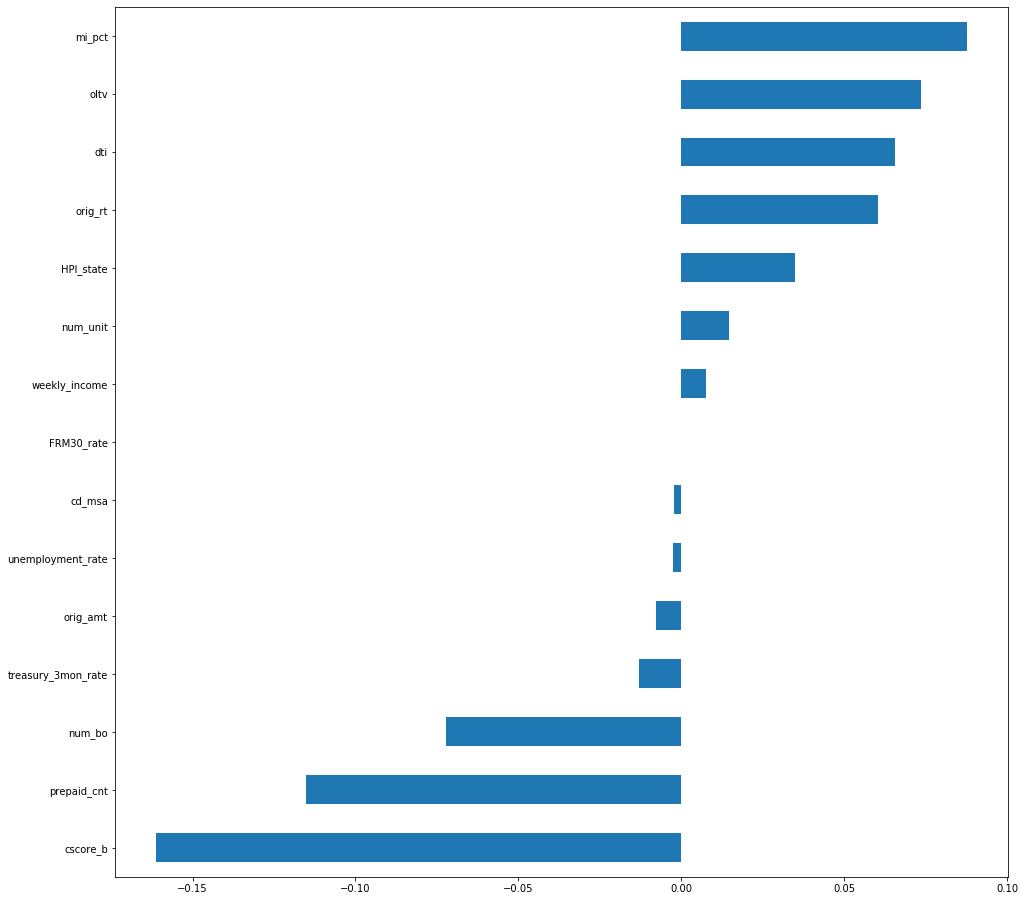

In [13]:
#看一看feature里和目标值的相关性；
#在这里，拖欠为90天以上的为失信
target = mortgage[['delinquent90']]
poly_features[['TARGET']] = target
poly_corrs = poly_features.corr()['TARGET'].sort_values()
poly_corrs = poly_corrs.drop(['TARGET'])
plt.figure(figsize = (16, 16))
poly_corrs.plot(kind='barh')

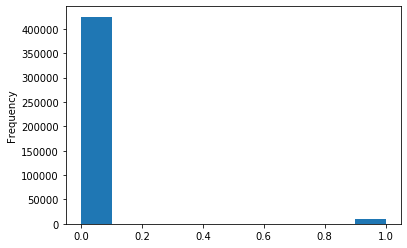

In [14]:
#看看失信的人占的比例
poly_features['TARGET'].astype(int).plot.hist()

In [15]:
#看完了，把那个目标值从特征的表里扔掉
poly_features.drop(['TARGET'],inplace=True,axis=1)

In [16]:
#特征值的类别在２个以上的使用one-hot编码，２个使用label编码．
# scikit-learn : LabelEncoder()
le = LabelEncoder()
col_name=[]
count = 0   #统计label编码特征数量
for col in poly_features:
    if len(list(poly_features[col].unique())) <=2:
        le.fit(poly_features[col])
        poly_features[col] = le.transform(poly_features[col])
        count = count + 1
        col_name.append(col)
print("%d 列特征是label编码"%count)
print(col_name)

2 列特征是label编码
['num_bo', 'prepaid_cnt']


In [17]:
#独热码，只有fthb_flg是
poly_features=pd.get_dummies(poly_features)
poly_features

,orig_rt,orig_amt,oltv,dti,cscore_b,mi_pct,num_bo,num_unit,cd_msa,prepaid_cnt,HPI_state,weekly_income,unemployment_rate,FRM30_rate,treasury_3mon_rate,fthb_flg_N,fthb_flg_U,fthb_flg_Y
0,8.500,204000,79,37,643,0,1,1,11260.000000,1,169.95000,674.0,7.4,8.2100,5.32,1,0,0
1,8.375,100000,34,19,796,0,1,1,30052.242044,1,169.95000,674.0,7.5,8.3250,5.55,1,0,0
2,8.500,173000,95,43,698,25,1,1,11260.000000,1,169.95000,674.0,7.2,8.2400,5.69,1,0,0
3,8.125,137000,80,28,716,0,1,1,30052.242044,1,209.11000,555.0,6.7,8.2100,5.32,1,0,0
4,8.250,92000,95,42,680,30,1,1,13820.000000,1,209.11000,555.0,6.4,8.3250,5.55,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434589,3.000,171000,95,29,786,30,0,1,30052.242044,0,270.35999,908.0,4.5,6.2175,4.98,0,0,1
434590,3.375,191000,95,27,798,30,0,1,30052.242044,0,270.35999,908.0,4.7,6.2850,5.03,1,0,0
434591,3.250,171000,90,33,768,25,1,1,30052.242044,0,270.35999,908.0,4.3,6.1560,4.94,1,0,0
434592,3.500,198000,80,41,772,0,1,1,30052.242044,0,270.35999,908.0,4.5,6.2175,4.98,1,0,0


In [18]:
#归一化
data = (poly_features-poly_features.mean())/poly_features.std() 

In [19]:
data

,orig_rt,orig_amt,oltv,dti,cscore_b,mi_pct,num_bo,num_unit,cd_msa,prepaid_cnt,HPI_state,weekly_income,unemployment_rate,FRM30_rate,treasury_3mon_rate,fthb_flg_N,fthb_flg_U,fthb_flg_Y
0,1.998161,0.260922,-0.055748,0.139808,-1.637692,-0.699230,0.860238,-0.123255,-1.807971e+00,1.008976,-1.365892,-0.656109,3.353699,2.118735,1.305367,0.633226,-0.017758,-0.632738
1,1.890677,-0.798183,-3.257758,-1.449067,1.172762,-0.699230,0.860238,-0.123255,1.389516e-13,1.008976,-1.365892,-0.656109,3.459596,2.265619,1.437611,0.633226,-0.017758,-0.632738
2,1.998161,-0.054773,1.082744,0.669433,-0.627398,1.252162,0.860238,-0.123255,-1.807971e+00,1.008976,-1.365892,-0.656109,3.141906,2.157052,1.518108,0.633226,-0.017758,-0.632738
3,1.675708,-0.421386,0.015408,-0.654629,-0.296756,-0.699230,0.860238,-0.123255,1.389516e-13,1.008976,-0.997905,-1.455905,2.612423,2.118735,1.305367,0.633226,-0.017758,-0.632738
4,1.783193,-0.879653,1.082744,0.581162,-0.958040,1.642440,0.860238,-0.123255,-1.561678e+00,1.008976,-0.997905,-1.455905,2.294734,2.265619,1.437611,0.633226,-0.017758,-0.632738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434589,-2.731152,-0.075140,1.082744,-0.566359,0.989073,1.642440,-1.162466,-0.123255,1.389516e-13,-0.991101,-0.422338,0.916601,0.282699,-0.426202,1.109875,-1.579211,-0.017758,1.580431
434590,-2.408699,0.128534,1.082744,-0.742900,1.209500,1.642440,-1.162466,-0.123255,1.389516e-13,-0.991101,-0.422338,0.916601,0.494491,-0.339987,1.138623,0.633226,-0.017758,-0.632738
434591,-2.516184,-0.075140,0.726966,-0.213275,0.658431,1.252162,0.860238,-0.123255,1.389516e-13,-0.991101,-0.422338,0.916601,0.070906,-0.504753,1.086876,0.633226,-0.017758,-0.632738
434592,-2.301215,0.199819,0.015408,0.492891,0.731907,-0.699230,0.860238,-0.123255,1.389516e-13,-0.991101,-0.422338,0.916601,0.282699,-0.426202,1.109875,0.633226,-0.017758,-0.632738


In [20]:
#这里没区分训练集和测试集

In [21]:
#逻辑回归
classifier = LogisticRegression(C = 0.01, class_weight ='balanced')
classifier.fit(data, target)
lr_poly_pred = classifier.predict_proba(data)[:,1]
print('predicr',lr_poly_pred)

predicr [0.3305691  0.00899898 0.29645215 ... 0.07380585 0.05869782 0.00816272]


In [22]:
#看一看效果
#scores = cross_val_score(classifier, data, target, cv=5)  
#print('准确率：',np.mean(scores), scores)  
#precisions = cross_val_score(classifier, data, target, cv=5, scoring='precision')  
#print('精确率：', np.mean(precisions), precisions)  
#recalls = cross_val_score(classifier, data, target, cv=5, scoring='recall')  
#print('召回率：', np.mean(recalls), recalls)  

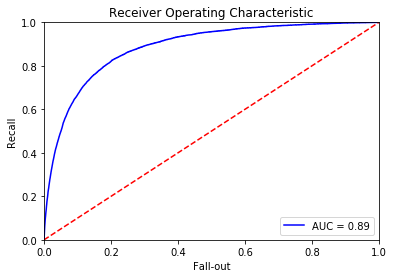

In [23]:
from sklearn.metrics import roc_curve, auc  
predictions = classifier.predict_proba(data)  
false_positive_rate, recall, thresholds = roc_curve(target, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Receiver Operating Characteristic')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out')  
plt.show()

In [24]:
#分训练集测试集
X_train,X_test, y_train, y_test =train_test_split(data,target,test_size=0.4, random_state=0,stratify=target)

In [25]:
X_train.shape,X_test.shape

((260756, 18), (173838, 18))

In [26]:
lr = LogisticRegression(C = 0.01, class_weight ='balanced')  
lr.fit(X_train, y_train)
lr_poly_pred = lr.predict_proba(X_test)[:,1]
cost = mortgage[['orig_amt']].iloc[260756:] #原始数据切片，获得测试集orig_amt的数据

In [27]:
#计算测试集的总利润
#thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#for j in thresholds: 
y_pre = []  #预测值二分类，0和1
for i in lr_poly_pred:
    if i>0.9:
        y_pre.append(1)
    else:
        y_pre.append(0)
        
profit1 = 0
profit2 = 0
for i in range(0,173838):
    if int(y_test.iloc[i]) == 0:
        factor1 = int(cost.iloc[i])*0.005
        if int(y_pre[i]) == 0:
            profit1 += factor1
        else:
            profit1 += 0
    else:
        factor2 = int(cost.iloc[i])*0.20
        if int(y_pre[i]) == 0:
            profit2 += -factor2
        else:
            profit2 += 0
profit = profit1 + profit2
print(profit)

55901075.0


Text(0.5, 1, 'Confusion matrix')

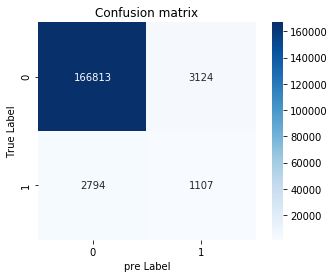

In [28]:
import sklearn
cnf_matrix = sklearn.metrics.confusion_matrix(y_test,y_pre)
import seaborn as sns
sns.heatmap(cnf_matrix,cmap="Blues",annot=True,fmt='d',square=True)
plt.ylabel('True Label')
plt.xlabel('pre Label')
plt.title('Confusion matrix')

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)#interpolation插值方式，#cmap表示绘图时的样式，cm是混淆矩阵
    plt.title(title)
    plt.colorbar()#给图配渐变色时，常常需要在图旁边把colorbar显示出来
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2. #阈值
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')